In [ ]:
!pip install -qqq --upgrade torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip install -qqq -U transformers onnxruntime>=1.4.0 onnxruntime-tools>=1.4.2 psutil

In [1]:
import inspect
import logging
import os
from pathlib import Path

import torch
from psutil import cpu_count
from transformers import T5Config, T5ForConditionalGeneration, T5Tokenizer
from transformers.generation_utils import GenerationMixin
from transformers.modeling_outputs import BaseModelOutputWithPast, Seq2SeqLMOutput

# Constants from the performance optimization available in onnxruntime
# It needs to be done before importing onnxruntime
os.environ["OMP_NUM_THREADS"] = str(cpu_count(logical=True))
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

from onnxruntime import GraphOptimizationLevel, InferenceSession, SessionOptions, get_all_providers

In [2]:
logger = logging.getLogger(__name__)

In [3]:
class T5Encoder(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder

    def forward(self, input_ids, attention_mask):
        return self.encoder(input_ids=input_ids, attention_mask=attention_mask)[0]


class T5Decoder(torch.nn.Module):
    def __init__(self, decoder, config):
        super().__init__()
        self.decoder = decoder
        self.config = config

    def forward(self, input_ids, encoder_hidden_states, attention_mask=None, past_key_values=None):
        past_arg_key = (
            "past_key_value_states"
            if "past_key_value_states" in inspect.getfullargspec(self.decoder.forward).args
            else "past_key_values"
        )
        past_arg = {past_arg_key: past_key_values}
        decoder_output = self.decoder(
            input_ids=input_ids,
            encoder_attention_mask=attention_mask,
            encoder_hidden_states=encoder_hidden_states,
            use_cache=True,
            return_dict=True,
            **past_arg,
        )
        past_key_values = decoder_output.past_key_values
        sequence_output = decoder_output.last_hidden_state
        sequence_output = sequence_output * (self.config.d_model ** -0.5)
        return sequence_output, past_key_values


class T5LMHead(torch.nn.Module):
    def __init__(self, lm_head):
        super().__init__()
        self.lm_head = lm_head

    def forward(self, decoder_output):
        return self.lm_head(decoder_output)


In [4]:
def create_t5_encoder_decoder(model="t5-base"):
    """Generates an encoder and a decoder model with a language model head from a pretrained huggingface model
    Args:
        model (str): Name of a pretrained model, or path to a pretrained / finetuned version of T5
    Returns:
        t5_encoder: pytorch t5 encoder with a wrapper to output only the hidden states
        t5_decoder: pytorch t5 decoder with a language modeling head
    """

    # T5 is an encoder / decoder model with a language modeling head on top.
    # We need to separate those out for efficient language generation
    if isinstance(model, str):
        model = T5ForConditionalGeneration.from_pretrained(model)

    encoder = model.encoder
    decoder = model.decoder
    lm_head = model.lm_head

    t5_encoder = T5Encoder(encoder).eval()
    t5_decoder = T5Decoder(decoder, model.config).eval()
    t5_lm_head = T5LMHead(lm_head).eval()
    return t5_encoder, t5_decoder, t5_lm_head

In [5]:
def generate_onnx_representation(model, encoder_path, lm_path):
    """Exports a given huggingface pretrained model, or a given model and tokenizer, to onnx
    Args:
        pretrained_version (str): Name of a pretrained model, or path to a pretrained / finetuned version of T5
        output_prefix (str): Path to the onnx file
    """

    simplified_encoder, decoder, lm_head = create_t5_encoder_decoder(model)

    # Example sequence
    tok = T5Tokenizer.from_pretrained(model)
    enc = tok("42 is the answer", return_tensors="pt")
    input_ids = enc["input_ids"]
    attention_mask = enc["attention_mask"]

    # Exports to ONNX
    _ = torch.onnx._export(
        simplified_encoder,
        (input_ids, attention_mask),
        encoder_path,
        export_params=True,
        opset_version=12,
        input_names=["input_ids", "attention_mask"],
        output_names=["encoder_hidden_states"],
        dynamic_axes={
            "input_ids": {0: "batch", 1: "sequence"},
            "attention_mask": {0: "batch", 1: "sequence"},
            "encoder_hidden_states": {0: "batch", 1: "sequence"},
        },
    )

    encoder_out = simplified_encoder(input_ids, attention_mask)
    decoder_out, _ = decoder(input_ids, encoder_out)
    _ = torch.onnx.export(
        lm_head,
        decoder_out,
        lm_path,
        export_params=True,
        opset_version=12,
        input_names=["decoder_output"],
        output_names=["lm_logits"],
        dynamic_axes={
            "decoder_output": {0: "batch", 1: "sequence"},
            "lm_logits": {0: "batch", 1: "sequence"},
        },
    )

In [6]:
def create_model_for_provider(model_path: str, provider: str) -> InferenceSession:

    assert provider in get_all_providers(), f"provider {provider} not found, {get_all_providers()}"

    # Few properties that might have an impact on performances (provided by MS)
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL

    # Load the model as a graph and prepare the CPU backend
    session = InferenceSession(model_path, options, providers=[provider])
    session.disable_fallback()

    return session

In [7]:
class OnnxT5(GenerationMixin):
    def __init__(self, model_name_or_path, onnx_path):

        self.model_name_or_path = Path(model_name_or_path)
        self.onnx_path = Path(onnx_path)
        self.mode_base_name = self.model_name_or_path.stem
        self.encoder_path = self.onnx_path.joinpath(f"{self.mode_base_name}_encoder.onnx")
        self.lm_head_path = self.onnx_path.joinpath(f"{self.mode_base_name}_lm_head.onnx")

        if not (self.encoder_path.exists() and self.lm_head_path.exists()):
            self._export_onnx_graph()

        self.encoder_sess = create_model_for_provider(self.encoder_path.as_posix(), "CPUExecutionProvider")
        self.lm_sess = create_model_for_provider(self.lm_head_path.as_posix(), "CPUExecutionProvider")

        self.config = T5Config.from_pretrained(model_name_or_path)
        decoder = T5ForConditionalGeneration.from_pretrained(model_name_or_path).decoder
        self.decoder = T5Decoder(decoder, self.config).eval()

        self._warmup_onnx_graph()

    @torch.no_grad()
    def __call__(
        self,
        input_ids=None,
        attention_mask=None,
        decoder_input_ids=None,
        encoder_outputs=None,
        past_key_values=None,
        **kwargs,
    ):
        if input_ids is not None:
            return self._encoder_forward(input_ids=input_ids, attention_mask=attention_mask)

        decoder_output, past = self.decoder(decoder_input_ids, encoder_outputs, attention_mask, past_key_values)

        inputs = {"decoder_output": decoder_output.cpu().detach().numpy()}
        lm_logits = self.lm_sess.run(None, inputs)[0]
        lm_logits = torch.from_numpy(lm_logits)
        return Seq2SeqLMOutput(logits=lm_logits, past_key_values=past)

    def _encoder_forward(self, input_ids=None, attention_mask=None):
        inputs = {
            "input_ids": input_ids.cpu().detach().numpy(),
            "attention_mask": attention_mask.cpu().detach().numpy(),
        }
        last_hidden_state = self.encoder_sess.run(None, inputs)[0]
        last_hidden_state = torch.from_numpy(last_hidden_state)
        return BaseModelOutputWithPast(last_hidden_state=last_hidden_state)

    def get_encoder(self):
        return self

    def get_output_embeddings(self):
        return self

    def prepare_inputs_for_generation(self, input_ids, past, attention_mask, use_cache, encoder_outputs, **kwargs):
        if past is not None:
            input_ids = input_ids[:, -1:]
        return {
            "decoder_input_ids": input_ids,
            "past_key_values": past,
            "encoder_outputs": encoder_outputs.last_hidden_state,
            "attention_mask": attention_mask,
            "use_cache": True,
        }

    def parameters(self):
        return iter(torch.tensor([42, 42]))

    def _export_onnx_graph(self):
        self.onnx_path.mkdir(parents=True, exist_ok=True)
        generate_onnx_representation(
            self.model_name_or_path.as_posix(), self.encoder_path.as_posix(), self.lm_head_path.as_posix()
        )

    def _reorder_cache(self, past, beam_idx):
        # if decoder past is not included in output
        # speedy decoding is disabled and no need to reorder
        if past is None:
            logger.warning("You might want to consider setting `use_cache=True` to speed up decoding")
            return past

        reordered_decoder_past = ()
        for layer_past_states in past:
            # get the correct batch idx from layer past batch dim
            # batch dim of `past` is at 2nd position
            reordered_layer_past_states = ()
            for layer_past_state in layer_past_states:
                # need to set correct `past` for each of the four key / value states
                reordered_layer_past_states = reordered_layer_past_states + (
                    layer_past_state.index_select(0, beam_idx),
                )

            assert reordered_layer_past_states[0].shape == layer_past_states[0].shape
            assert len(reordered_layer_past_states) == len(layer_past_states)

            reordered_decoder_past = reordered_decoder_past + (reordered_layer_past_states,)
        return reordered_decoder_past

    def _warmup_onnx_graph(self):
        input_ids = torch.ones(1, 512, dtype=torch.long)
        attention_mask = torch.ones(1, 512, dtype=torch.long)
        for _ in range(10):
            encoder_outputs = self._encoder_forward(
                input_ids=input_ids, attention_mask=attention_mask
            ).last_hidden_state

        decoder_output, _ = self.decoder(input_ids, encoder_outputs, attention_mask)
        inputs = {"decoder_output": decoder_output.cpu().detach().numpy()}
        for _ in range(10):
            self.lm_sess.run(None, inputs)

In [8]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [9]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")
enc = tokenizer("translate English to French: 42 is the answer to life the universe and everything.", return_tensors="pt")

In [10]:
onnx_model = OnnxT5(model_name_or_path="t5-small", onnx_path="onnx_models")

In [11]:
tokens = onnx_model.generate(**enc, num_beams=2, use_cache=True) # same HF's generate method
tokenizer.batch_decode(tokens)

["42 est la réponse à la vie l'univers et tout."]

### Benchmark

In [ ]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import os


def plot_benchmark(results):
    # Compute average inference time + std
    time_results = {k: np.mean(v.model_inference_time) * 1e3 for k, v in results.items()}
    time_results_std = np.std([v.model_inference_time for v in results.values()]) * 1000

    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_ylabel("Avg Inference time (ms)")
    ax.set_title("Average inference time (ms) for each provider")
    ax.bar(time_results.keys(), time_results.values(), yerr=time_results_std)
    plt.show()

from contextlib import contextmanager
from dataclasses import dataclass
from time import time
from tqdm import trange

@contextmanager
def track_infer_time(buffer: [int]):
    start = time()
    yield
    end = time()

    buffer.append(end - start)

@dataclass
class OnnxInferenceResult:
  model_inference_time: [int]  
  optimized_model_path: str

In [ ]:
torch_model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [ ]:
ARTICLE_SUBWAY = 'summarize: New York (CNN)When Liana Barrientos was 23 years old, she got married in Westchester County, New York. A year later, she got married again in Westchester County, but to a different man and without divorcing her first husband.  Only 18 days after that marriage, she got hitched yet again. Then, Barrientos declared "I do" five more times, sometimes only within two weeks of each other. In 2010, she married once more, this time in the Bronx. In an application for a marriage license, she stated it was her "first and only" marriage. Barrientos, now 39, is facing two criminal counts of "offering a false instrument for filing in the first degree," referring to her false statements on the 2010 marriage license application, according to court documents. Prosecutors said the marriages were part of an immigration scam. On Friday, she pleaded not guilty at State Supreme Court in the Bronx, according to her attorney, Christopher Wright, who declined to comment further. After leaving court, Barrientos was arrested and charged with theft of service and criminal trespass for allegedly sneaking into the New York subway through an emergency exit, said Detective Annette Markowski, a police spokeswoman. In total, Barrientos has been married 10 times, with nine of her marriages occurring between 1999 and 2002.  All occurred either in Westchester County, Long Island, New Jersey or the Bronx. She is believed to still be married to four men, and at one time, she was married to eight men at once, prosecutors say. Prosecutors said the immigration scam involved some of her husbands, who filed for permanent residence status shortly after the marriages.  Any divorces happened only after such filings were approved. It was unclear whether any of the men will be prosecuted. The case was referred to the Bronx District Attorney\'s Office by Immigration and Customs Enforcement and the Department of Homeland Security\'s Investigation Division. Seven of the men are from so-called "red-flagged" countries, including Egypt, Turkey, Georgia, Pakistan and Mali. Her eighth husband, Rashid Rajput, was deported in 2006 to his native Pakistan after an investigation by the Joint Terrorism Task Force. If convicted, Barrientos faces up to four years in prison.  Her next court appearance is scheduled for May 18.'
enc = tokenizer(ARTICLE_SUBWAY, truncation=True, return_tensors="pt")

In [ ]:
models = [("torch", torch_model), ("onnx", onnx_model)]
results = {}
for label, model in models:
    # Compute 
    time_buffer = []
    for _ in trange(100, desc=f"Tracking inference time for {label}"):
        with track_infer_time(time_buffer):
            model.generate(
                **enc,
                num_beams=4,
                length_penalty=2.0,
                max_length=142,
                min_length=56,
                no_repeat_ngram_size=3,
                do_sample=False,
                early_stopping=True
            )

        # Store the result
        results[label] = OnnxInferenceResult(
            time_buffer, 
            None
        )

Tracking inference time for onnx: 100%|██████████| 100/100 [06:00<00:00,  3.60s/it]


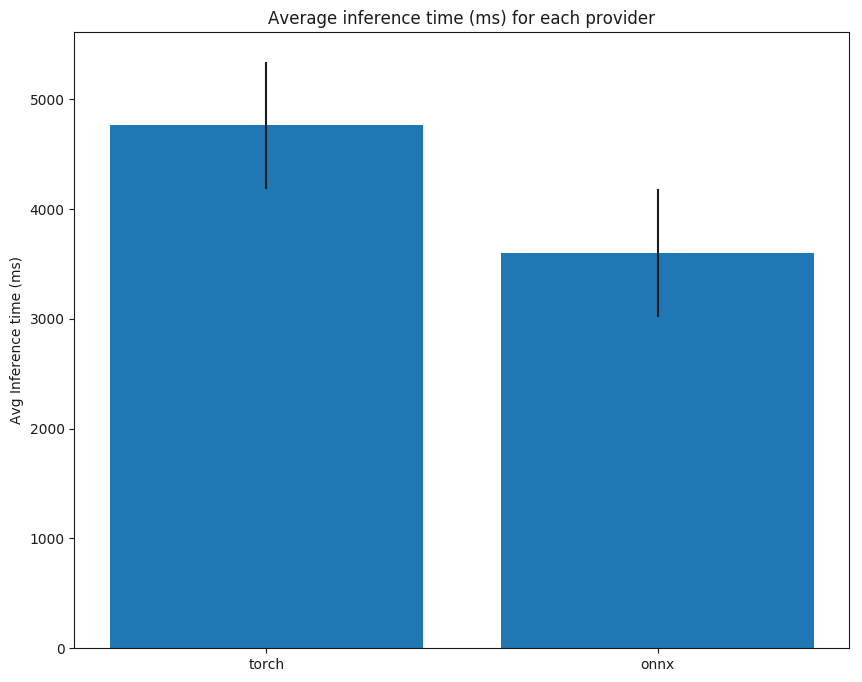

In [ ]:
plot_benchmark(results)

In [ ]:
en_text = 'translate English to French: This image section from an infrared recording by the Spitzer telescope shows a "family portrait" of countless generations of stars: the oldest stars are seen as blue dots. '
enc = tokenizer(en_text, truncation=True, return_tensors="pt")

In [ ]:
results = {}
for label, model in models:
    # Compute 
    time_buffer = []
    for _ in trange(100, desc=f"Tracking inference time for {label}"):
        with track_infer_time(time_buffer):
            model.generate(
                **enc,
                num_beams=4,
                length_penalty=2.0,
                max_length=100,
                no_repeat_ngram_size=3,
                do_sample=False,
                early_stopping=True,
            )

        # Store the result
        results[label] = OnnxInferenceResult(
            time_buffer, 
            None
        )

Tracking inference time for onnx: 100%|██████████| 100/100 [03:14<00:00,  1.95s/it]


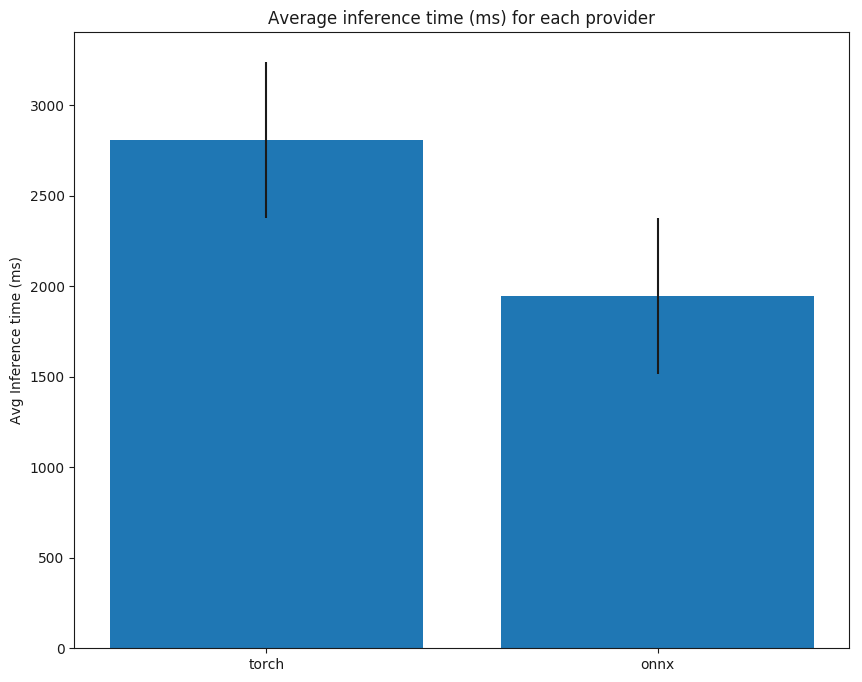

In [ ]:
plot_benchmark(results)